# Reconocimiento de vocales

## Estandarización del formato de los audios capturados a `.wav`.

Por defecto:
* Whatsapp: `*.ogg`
* Grabadora de voz win10: `*.m4a`

In [ ]:
# Para correr en google colab

from google.colab import drive
import sys
import os

# Conecta drive a colab
drive.mount('/content/drive')
sys.path.insert(0, '/content/drive/MyDrive/Education/urosario/github/macc/machine learning/Proyecto 2 - reconocimiento vocales NN')

# asigna la ruta de trabajo del proyecto dentro del drive
os.chdir('/content/drive/MyDrive/Education/urosario/github/macc/machine learning/Proyecto 2 - reconocimiento vocales NN')

In [1]:
# importa librerias y define rutas
import os 
import glob
import librosa
import soundfile 

CURRENT_PATH = os.getcwd()
SAMPLES_PATH = os.path.join(CURRENT_PATH, 'database')


In [ ]:
# Transforma todos los audios a formato .wav

import warnings
warnings.filterwarnings("ignore")

for format in ['ogg', 'm4a']:
    for vowel in ['a', 'e', 'i', 'o', 'u']:
        # absolute path to search all text files inside a specific folder
        path = os.path.join(SAMPLES_PATH, f'{vowel}', f'*.{format}')
        #print(path)
        files = glob.glob(path)
        #print(files)
        i = 1
        for file in files:
          print("in for cycle for change format")
          audio, sr = librosa.load(str(file), sr = 16000)
          #soundfile.write("test file.wav", audio ,16000)
          soundfile.write(os.path.join(SAMPLES_PATH, f'{vowel}', f'{vowel}t_({i}).wav'), audio ,16000)
          i+=1            

          if os.path.exists(file):
            print(f"file {file} deleted!")
            os.remove(file)           

## Cargando un archivo de audio

In [11]:
import librosa

audio_path = os.path.join(SAMPLES_PATH, 'a', 'a_(3).wav')
audio, sr = librosa.load(audio_path, sr = 16000)

## Reproduciendo el audio

In [12]:
import IPython.display as ipd

ipd.Audio(audio_path) # no se puede reproducir en vscode :/

## Visualizando el audio

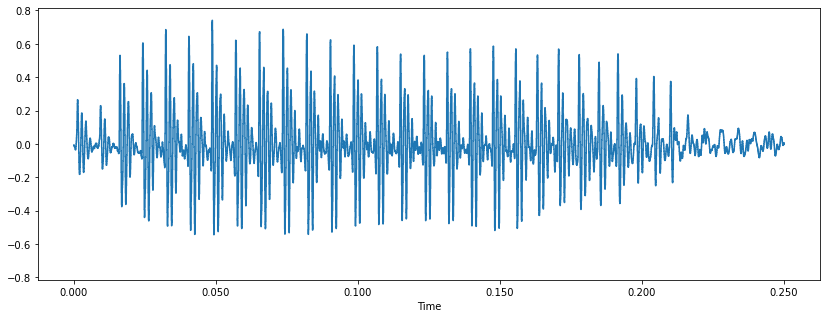

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr) # cambiar waveplot por waveshow, para librosa>=0.9

## Generando el espectograma

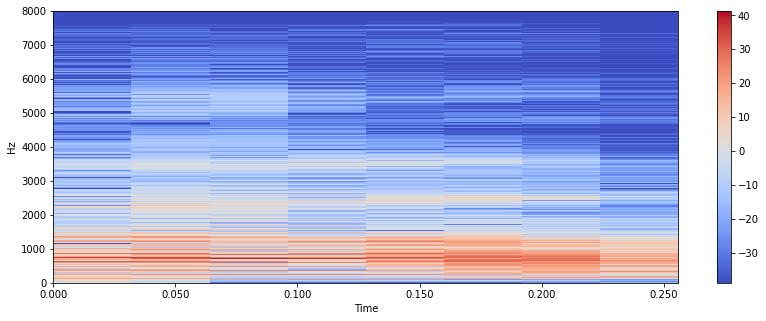

In [14]:
X = librosa.stft(audio)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

# Extracción de propiedades del audio

## Centroide espectral

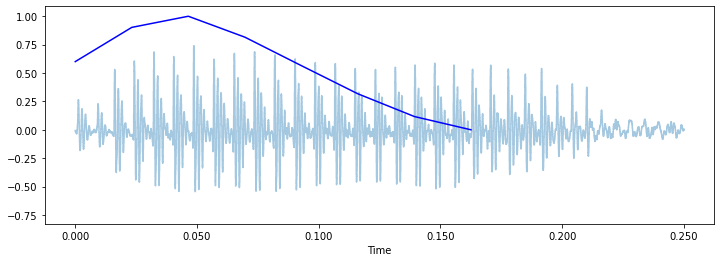

In [15]:
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(audio, sr=sr)[0]
spectral_centroids.shape
#(775,)

# Computing the time variable for visualization
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(audio, axis=0):
    return sklearn.preprocessing.minmax_scale(audio, axis=axis)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(audio, sr=sr, alpha=0.4) # cambiar waveplot por waveshow
plt.plot(t, normalize(spectral_centroids), color='b')

## Spectral rolloff

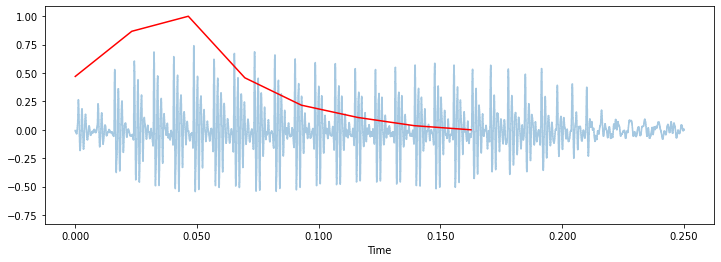

In [16]:
spectral_rolloff = librosa.feature.spectral_rolloff(audio+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))

librosa.display.waveshow(audio, sr=sr, alpha=0.4) # waveshow
plt.plot(t, normalize(spectral_rolloff), color='r')

## Ancho de banda espectral

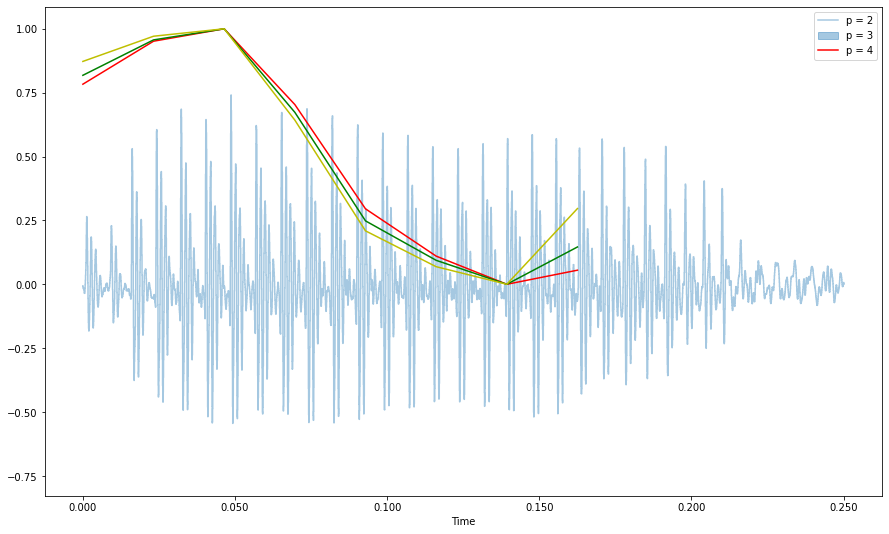

In [17]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(audio+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(audio+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(audio+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))

librosa.display.waveshow(audio, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

## Zero-Crossing Rate

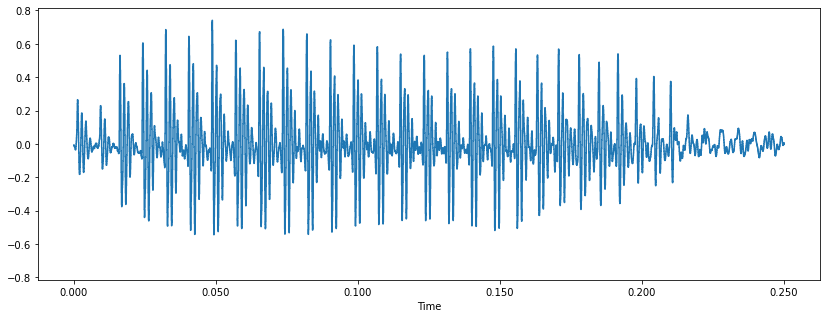

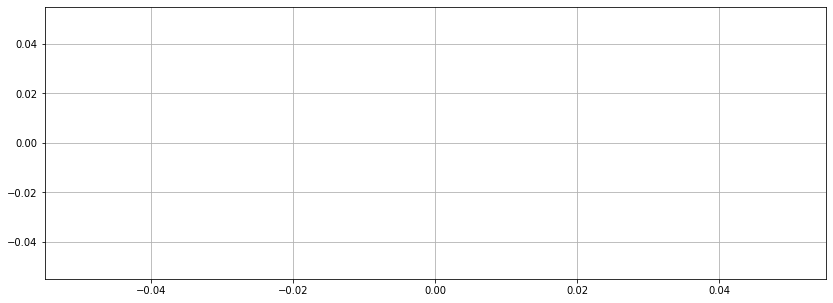

In [18]:
#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(audio[n0:n1])
plt.grid()

## Mel-Frequency Cepstral Coefficients(MFCCs)

(20, 8)


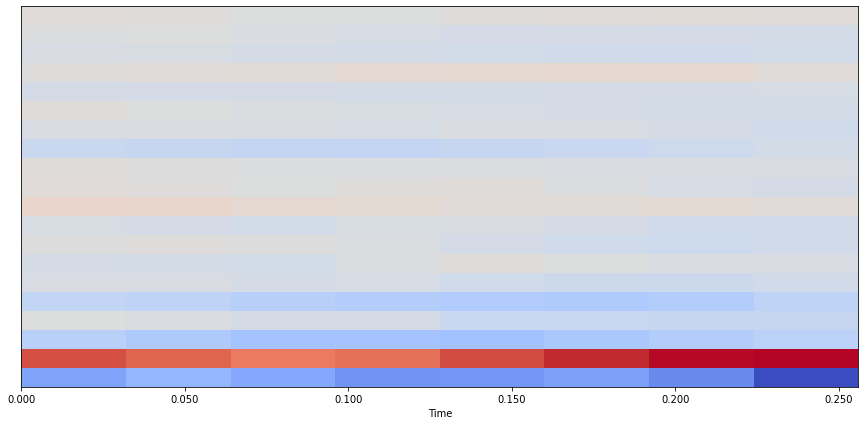

In [19]:
mfccs = librosa.feature.mfcc(audio, sr=sr)
print(mfccs.shape)
#(20, 97)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

## Chroma feature

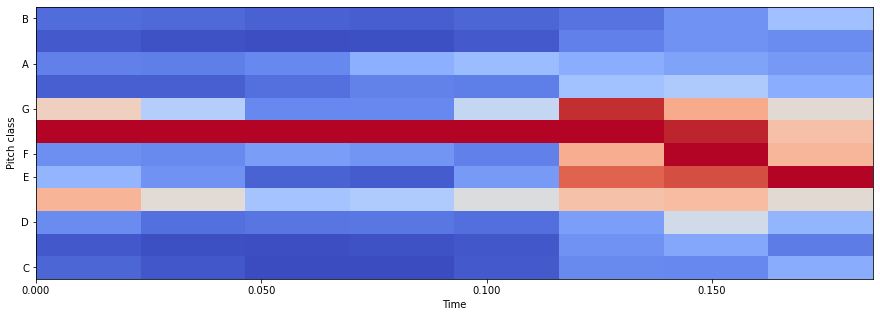

In [20]:
chromagram = librosa.feature.chroma_stft(audio, sr=sr, hop_length=512) # hop_lengt 512 según ejemplo
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

# Clasificación de audio usando ANN

First of all, we need to convert the audio files into PNG format images(spectrograms). From these spectrograms, we have to extract meaningful features, i.e. MFCCs, Spectral Centroid, Zero Crossing Rate, Chroma Frequencies, Spectral Roll-off. Once the features have been extracted, they can be appended into a CSV file so that ANN can be used for classification. If we wanna work with image data instead of CSV we will use CNN.

So let's begin.

In [2]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras import layers
import keras
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

## Transformar audios en espectogramas (png)

In [25]:
IMAGES_PATH = os.path.join(CURRENT_PATH, 'images')

cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
vowels = 'a e i o u'.split()
for vowel in vowels:
    for filename in os.listdir(os.path.join(SAMPLES_PATH, f'{vowel}'))[1:]: # debe empeza desde index 1 para no tener en cuenta la carpeta checkpoints 
        vowel_sample = os.path.join(SAMPLES_PATH, f'{vowel}', filename)
        if filename == 'desktop.ini': # omite desktop.ini
            break
        print(filename)
        sample, sr = librosa.load(vowel_sample, mono=True, duration=5)
        plt.specgram(sample, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB')
        plt.axis('off')
        plt.savefig(os.path.join(IMAGES_PATH, f'{vowel}', f'{filename[:-3].replace(".", "")}.png')) # plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

a_(1).wav
a_(10).wav
a_(100).wav
a_(101).wav
a_(102).wav
a_(103).wav
a_(104).wav
a_(105).wav
a_(106).wav
a_(107).wav
a_(108).wav
a_(109).wav
a_(11).wav
a_(110).wav
a_(111).wav
a_(112).wav
a_(113).wav
a_(114).wav
a_(115).wav
a_(116).wav
a_(117).wav
a_(118).wav
a_(119).wav
a_(12).wav
a_(120).wav
a_(121).wav
a_(122).wav
a_(123).wav
a_(124).wav
a_(125).wav
a_(126).wav
a_(127).wav
a_(128).wav
a_(129).wav
a_(13).wav
a_(130).wav
a_(131).wav
a_(132).wav
a_(133).wav
a_(134).wav
a_(135).wav
a_(136).wav
a_(137).wav
a_(138).wav
a_(139).wav
a_(14).wav
a_(140).wav
a_(141).wav
a_(142).wav
a_(143).wav
a_(144).wav
a_(145).wav
a_(146).wav
a_(147).wav
a_(148).wav
a_(149).wav
a_(15).wav
a_(150).wav
a_(151).wav
a_(152).wav
a_(153).wav
a_(154).wav
a_(155).wav
a_(156).wav
a_(157).wav
a_(158).wav
a_(159).wav
a_(16).wav
a_(160).wav
a_(161).wav
a_(162).wav
a_(163).wav
a_(164).wav
a_(165).wav
a_(166).wav
a_(167).wav
a_(168).wav
a_(169).wav
a_(17).wav
a_(170).wav
a_(171).wav
a_(172).wav
a_(173).wav
a_(174).wav
a_

<Figure size 576x576 with 0 Axes>

## Creando csv con atributos de los audios

In [28]:
CSV_PATH = os.path.join(CURRENT_PATH, 'csv')

header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'

for i in range(1, 21):
    header += f' mfcc{i}'

header += ' label'
header = header.split()

file = open(os.path.join(CSV_PATH, 'dataset.csv'), 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

vowels = 'a e i o u'.split()

for vowel in vowels:
    for filename in os.listdir(os.path.join(SAMPLES_PATH, f'{vowel}'))[1:]:
        vowel_sample = os.path.join(SAMPLES_PATH, f'{vowel}', filename) 
        if filename == 'desktop.ini': # omite desktop.ini
            break
        y, sr = librosa.load(vowel_sample, mono=True, duration=30)
        rms = librosa.feature.rms(y=y) # The latest librosa replaced rmse with rms, 
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        
        to_append += f' {vowel}'
        file = open(os.path.join(CSV_PATH, 'dataset.csv'), 'a', newline='')
        
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

## Dividiendo el conjunto de datos en train y test

In [62]:
data = pd.read_csv(os.path.join(CSV_PATH, 'dataset.csv'))
data.head()# Dropping unneccesary columns


,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,a_(1).wav,0.370680,0.078709,1352.361637,1586.222325,2417.909546,0.061951,-195.161057,155.052734,-32.641567,...,-0.047796,-13.109210,-4.159160,-5.533259,-2.612540,-6.622783,-3.217532,-5.889333,-0.514631,a
1,a_(10).wav,0.335633,0.070051,1338.283847,1612.799946,2347.771662,0.058579,-226.271652,156.350143,-21.872320,...,3.293402,-7.723278,-6.780663,-7.603872,-3.309390,-8.553095,-2.232722,-5.898294,-2.178934,a
2,a_(100).wav,0.239790,0.183272,1230.132660,1299.195610,2052.114258,0.065283,-174.567352,165.541260,-52.337463,...,15.753389,-3.234526,-29.682825,-6.204116,0.529301,-4.536174,0.653478,0.554122,4.489969,a
3,a_(101).wav,0.297563,0.164784,1118.158996,1174.958891,1484.252930,0.060955,-186.666275,182.520905,-34.975822,...,-1.141479,2.006813,-26.574198,-14.252640,-2.554953,-30.448599,3.288739,0.205309,-8.175979,a
4,a_(102).wav,0.322532,0.127276,1354.768330,1534.176402,2566.734659,0.064758,-185.748901,162.806931,-37.369774,...,-0.047263,-5.125896,-18.035034,-8.185450,4.124800,-9.562122,-1.907890,-1.267814,-3.732115,a


In [63]:
data = data.drop(['filename'],axis=1)#Encoding the Labels
vowel = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(vowel)#Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [65]:
y

array([0, 0, 0, ..., 4, 4, 4])

## Construyendo la ANN

In [31]:
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',   
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

classifier = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128)



Epoch 1/100
9/9 [==============================] - 1s 3ms/step - loss: 1.8288 - accuracy: 0.4838
Epoch 2/100
9/9 [==============================] - 0s 4ms/step - loss: 0.9618 - accuracy: 0.7891
Epoch 3/100
9/9 [==============================] - 0s 4ms/step - loss: 0.5147 - accuracy: 0.8677
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 0.3633 - accuracy: 0.8742
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 0.3042 - accuracy: 0.8982
Epoch 6/100
9/9 [==============================] - 0s 4ms/step - loss: 0.2653 - accuracy: 0.9056
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2373 - accuracy: 0.9214
Epoch 8/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2215 - accuracy: 0.9214
Epoch 9/100
9/9 [==============================] - 0s 5ms/step - loss: 0.2036 - accuracy: 0.9352
Epoch 10/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1876 - accuracy: 0.9278
Epoch 11/100
9/9 [===========

In [81]:
predict_x=model.predict(X_test[0:2]) 
classes_x=np.argmax(predict_x,axis=1)
pred_str = str(encoder.inverse_transform(classes_x))
test_str = encoder.inverse_transform(y_test[0:2])

print(f"la muestra corresponde a las vocales {test_str}, la predicción es {pred_str}")

la muestra corresponde a las vocales ['i' 'a'], la predicción es ['i' 'a']


In [66]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 1ms/step - loss: 0.1086 - accuracy: 0.9889


[0.10861841589212418, 0.9889298677444458]

# Referencias

[Sound Visualization](https://maelfabien.github.io/machinelearning/Speech10/#)

[Vibration Analysis: FFT, PSD, and Spectrogram Basics](https://blog.endaq.com/vibration-analysis-fft-psd-and-spectrogram)

[The Power Spectrum](https://mark-kramer.github.io/Case-Studies-Python/03.html)

[Formate](https://es.wikipedia.org/wiki/Formante)

[Las características acústicas de los elementos segmentales](http://liceu.uab.es/~joaquim/phonetics/fon_anal_acus/caract_acust.html): Acá hay una imagen de los espectrogramas de las vocales, en donde se identifican los formantes. 

[Audio Deep Learning Made Simple: Sound Classification, Step-by-Step](https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5)

[Introduction to Audio Classification](https://www.analyticsvidhya.com/blog/2021/06/introduction-to-audio-classification/)

[Audio Data Analysis Using Deep Learning with Python (Part 1)](https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html)